In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ShuffleSplit
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import NearestCentroid
from scipy.cluster.hierarchy import dendrogram, linkage

In [2]:
import warnings
warnings.filterwarnings('ignore')

plt.style.use('bmh')

In [3]:
def plot_graph(x_label, y_label, method, values, max_x_value=0, start=2):
    fig = plt.figure(figsize=(18, 6))
    plt.plot(range(start, len(values) + start), values, color='#FF817E')
    plt.scatter(range(start, len(values) + start), values, color='#FF4F4B')
    
    if method=='Average silhouette method':
        plt.axvline(x=max_x_value, color='#FF0500', linestyle='--', label='Максимальне значення')
    elif method=='Prediction strength method':
        plt.axhline(y=0.8, color='#FF0500', linestyle='--', label='Baseline')

    plt.xticks(range(start, len(values) + start))
    if method=='Prediction strength method':
        plt.yticks(np.arange(0, 1.01, 0.1))
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid(True)
    plt.title(method)
    plt.show()

# 1. Відкрити та зчитати наданий файл з даними.

In [4]:
temp_df = pd.read_csv('dataset3_l5.csv')
temp_df

Cement (component 1)(kg in a m^3 mixture);Blast Furnace Slag (component 2)(kg in a m^3 mixture);Fly Ash (component 3)(kg in a m^3 mixture);Water  (component 4)(kg in a m^3 mixture);Superplasticizer (component 5)(kg in a m^3 mixture);Coarse Aggregate  (component 6)(kg in a m^3 mixture);Fine Aggregate (component 7)(kg in a m^3 mixture);Age (day);Concrete compressive strength(MPa  \
540 0 ;0   0 ;0   0 ;162 0 ;2  5 ;1040 0 ;676                                          0 ;28 ;79                                                                                                                                                                                                                                                                                                                                            
                               5 ;1055 0 ;676                                          0 ;28 ;61                                                                                                                                                                                                                                                                                                                                            
332 5 ;142 5 ;0   0 ;228 0 ;0  0 ;932  0 ;594                                         0 ;270 ;40                                                                                                                                                                                                                                                                                                                                            
                                       0 ;594                                         0 ;365 ;41                                                                                                                                                                                                                                                                                                                                            
198 6 ;132 4 ;0   0 ;192 0 ;0  0 ;978  4 ;825                                         5 ;360 ;44                                                                                                                                                                                                                                                                                                                                            
...                                                                                          ...                                                                                                                                                                                                                                                                                                                                            
276 4 ;116 0 ;90  3 ;179 6 ;8  9 ;870  1 ;768                                          3 ;28 ;44                                                                                                                                                                                                                                                                                                                                            
322 2 ;0   0 ;115 6 ;196 0 ;10 4 ;817  9 ;813                                          4 ;28 ;31                                                                                                                                                                                                                                                                                                                                            
148 5 ;139 4 ;108 6 ;192 7 ;6  1 ;892  4 ;780                                          0 ;28 ;23                                                                                         

Як бачимо, при зчитуванні датасету отримуємо досить неочікуваний результат. Справа в тому, що оригінальний csv-файл не був приведений до охайного вигляду. Назви атрибутів збиті в дві клітинки, а значення атрибутів у записах некоректним чином вписані у комірки. Для того щоб позбавитися цього недоліку, оскільки pandas.read_csv зчитує csv-файл рядок за рядком, то достатньо при зчитуванні датасету вказати аргумент delimeter=';', оскільки значення в датасеті розділені саме цим роздільним символом: 

In [5]:
df = pd.read_csv('dataset3_l5.csv', delimiter=';')
df

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,"540,0","0,0","0,0","162,0","2,5","1040,0","676,0",28,"79,99"
1,"540,0","0,0","0,0","162,0","2,5","1055,0","676,0",28,"61,89"
2,"332,5","142,5","0,0","228,0","0,0","932,0","594,0",270,"40,27"
3,"332,5","142,5","0,0","228,0","0,0","932,0","594,0",365,"41,05"
4,"198,6","132,4","0,0","192,0","0,0","978,4","825,5",360,"44,30"
...,...,...,...,...,...,...,...,...,...
1025,"276,4","116,0","90,3","179,6","8,9","870,1","768,3",28,"44,28"
1026,"322,2","0,0","115,6","196,0","10,4","817,9","813,4",28,"31,18"
1027,"148,5","139,4","108,6","192,7","6,1","892,4","780,0",28,"23,70"
1028,"159,1","186,7","0,0","175,6","11,3","989,6","788,9",28,"32,77"


Окрім того, варто звернути увагу на числові значення атрибутів у записах. Справа в тому, що в програмному середовищі за замовчуванням кома не може бути десятковим розділювачем. Тобто наші значення не є числовими: відповідні числові записи знаходяться у строковому форматі, або ж, іншими словами, мають тип object:

In [6]:
df.dtypes

Cement (component 1)(kg in a m^3 mixture)                object
Blast Furnace Slag (component 2)(kg in a m^3 mixture)    object
Fly Ash (component 3)(kg in a m^3 mixture)               object
Water  (component 4)(kg in a m^3 mixture)                object
Superplasticizer (component 5)(kg in a m^3 mixture)      object
Coarse Aggregate  (component 6)(kg in a m^3 mixture)     object
Fine Aggregate (component 7)(kg in a m^3 mixture)        object
Age (day)                                                 int64
Concrete compressive strength(MPa, megapascals)          object
dtype: object

Приведемо відповідні значення до числового формату (float типу):

In [7]:
for col in df.select_dtypes(['object']).columns:
    df[col] = df[col].str.replace(',', '.').astype(float)
df

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30
...,...,...,...,...,...,...,...,...,...
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.18
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.70
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.77


In [8]:
df.dtypes

Cement (component 1)(kg in a m^3 mixture)                float64
Blast Furnace Slag (component 2)(kg in a m^3 mixture)    float64
Fly Ash (component 3)(kg in a m^3 mixture)               float64
Water  (component 4)(kg in a m^3 mixture)                float64
Superplasticizer (component 5)(kg in a m^3 mixture)      float64
Coarse Aggregate  (component 6)(kg in a m^3 mixture)     float64
Fine Aggregate (component 7)(kg in a m^3 mixture)        float64
Age (day)                                                  int64
Concrete compressive strength(MPa, megapascals)          float64
dtype: object

# 2. Визначити та вивести кількість записів. 

In [9]:
print(f'Кількість записів: {len(df)}')

Кількість записів: 1030


# 3. 
Видалити атрибут ***Concrete compressive strength***.

In [10]:
del_attribute = 'Concrete compressive strength'

In [11]:
previous_attributes = df.columns

In [12]:
print(f'Список атрибутів до видалення: \n{previous_attributes}')

Список атрибутів до видалення: 
Index(['Cement (component 1)(kg in a m^3 mixture)',
       'Blast Furnace Slag (component 2)(kg in a m^3 mixture)',
       'Fly Ash (component 3)(kg in a m^3 mixture)',
       'Water  (component 4)(kg in a m^3 mixture)',
       'Superplasticizer (component 5)(kg in a m^3 mixture)',
       'Coarse Aggregate  (component 6)(kg in a m^3 mixture)',
       'Fine Aggregate (component 7)(kg in a m^3 mixture)', 'Age (day)',
       'Concrete compressive strength(MPa, megapascals) '],
      dtype='object')


In [13]:
for column in df.columns:
    if del_attribute in column:
        df.drop(column, axis=1, inplace=True)

In [14]:
current_attributes = df.columns
deleted = list(set(previous_attributes) ^ set(current_attributes))

In [15]:
print(f'Видалені атрибути: \n{deleted}')

Видалені атрибути: 
['Concrete compressive strength(MPa, megapascals) ']


# 4. Вивести атрибути, що залишилися:

In [16]:
print(f'Список атрибутів після видалення: \n{current_attributes}')

Список атрибутів після видалення: 
Index(['Cement (component 1)(kg in a m^3 mixture)',
       'Blast Furnace Slag (component 2)(kg in a m^3 mixture)',
       'Fly Ash (component 3)(kg in a m^3 mixture)',
       'Water  (component 4)(kg in a m^3 mixture)',
       'Superplasticizer (component 5)(kg in a m^3 mixture)',
       'Coarse Aggregate  (component 6)(kg in a m^3 mixture)',
       'Fine Aggregate (component 7)(kg in a m^3 mixture)', 'Age (day)'],
      dtype='object')


Датасет після видалення відповідних атрибутів:

In [17]:
df

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day)
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360
...,...,...,...,...,...,...,...,...
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28


# 5. 
Використовуючи функцію ***KMeans*** бібліотеки ***scikit-learn***, виконати розбиття набору даних на кластери з випадковою початковою ініціалізацією і вивести координати центрів кластерів.

Оптимальну кількість кластерів визначити на основі початкового набору даних трьома різними способами:
1) elbow method;

2) average silhouette method;

3) prediction strength method (див. *п. 9.2.3 Determining the Number of Clusters* книжки ***Andriy Burkov. The Hundred-Page Machine Learning Book***).

Отримані результати порівняти і пояснити, який метод дав кращий результат і чому так (на Вашу думку)

#### Як працює алгоритм KMeans?

Розглянемо step by step що відбувається у KMeans алгоритмі. Його робота починається з того, що ми з нашого датасету обираємо K початкових точок, які слугуватимуть нам центроїдами для першої ітерації: 

<div>
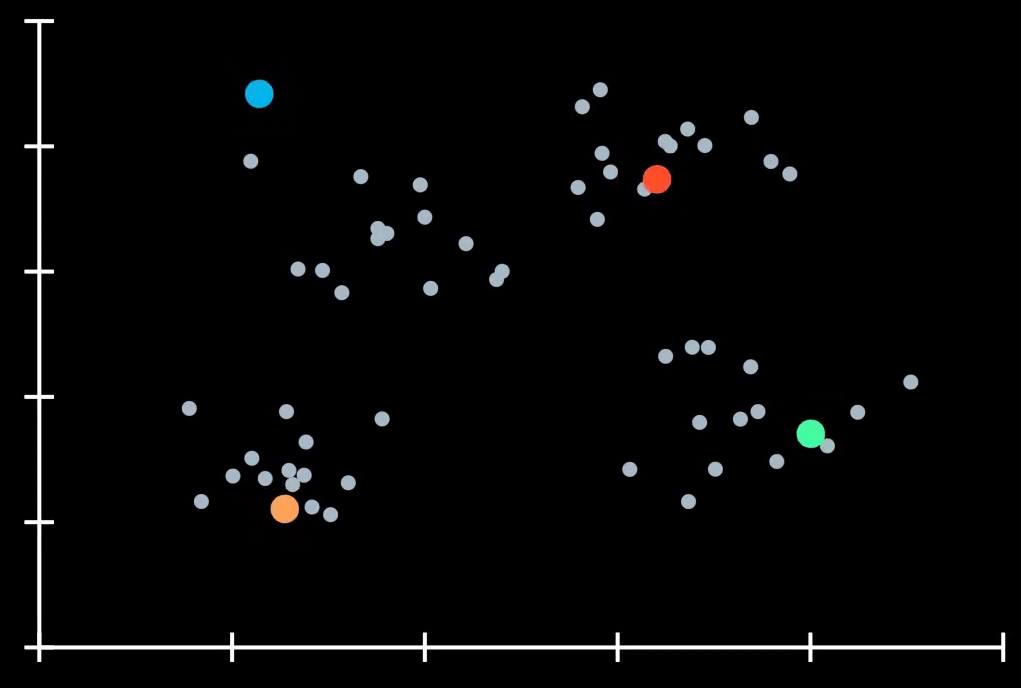
</div>

Далі, оскільки усі значення в нашому датасеті мають числовий тип, то за допомогою евклідової відстані ми обраховуємо для  для кожної точки (кожного запису) з датасету відстань від неї до кожного з центроїдів, після чого асоціюємо її з тим центроїдом, що є найближчим:

<div>
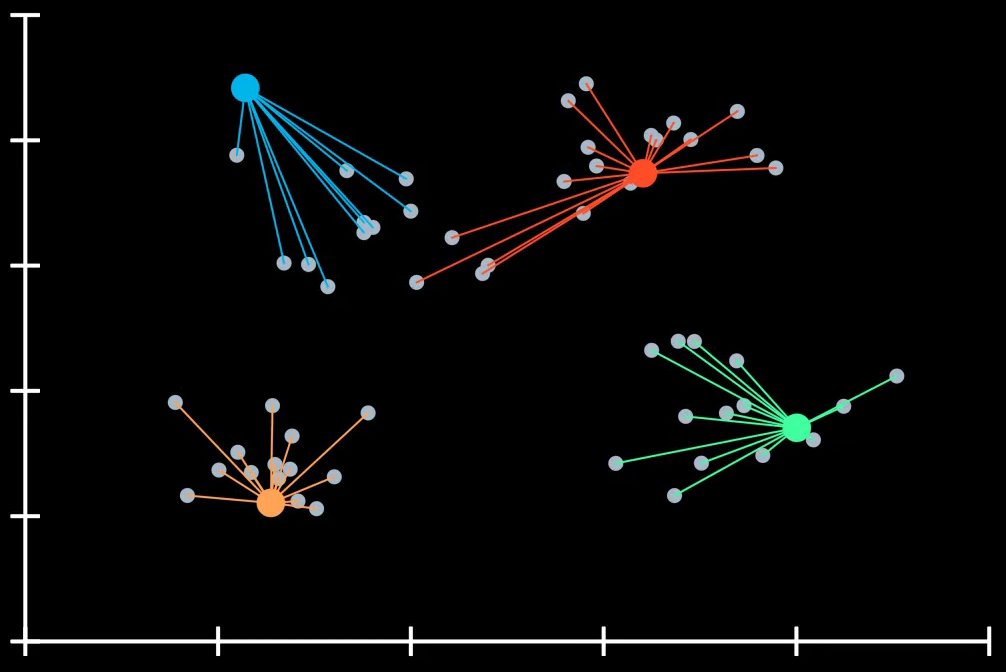
</div>

Наприкінці першої ітерації ми поокремо беремо кожен з утворених кластерів і вираховуємо для них координати усередненої точки, тобто беремо кожну точку всередині кластера та обраховуємо середні значення по кожній з фіч (просторових вісей): 

<div>
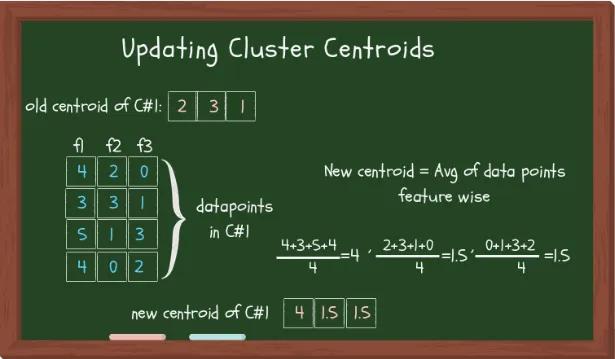
</div>

В результаті такої процедури отримаємо наступний результат:

<div>
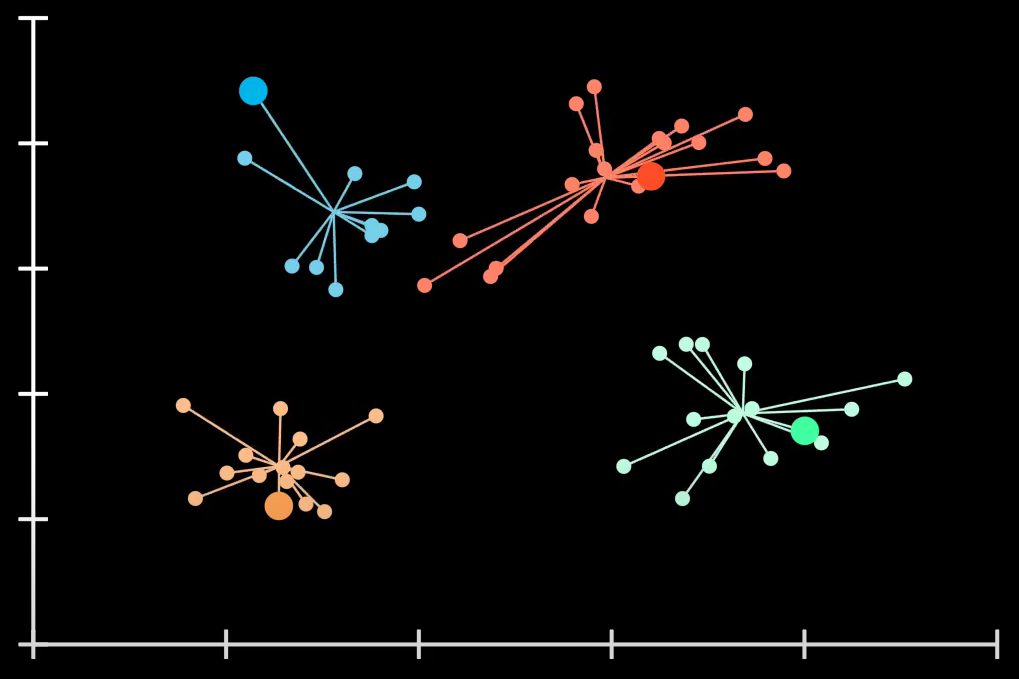
</div>

Таким чином алгоритм KMeans виконує мінімізацію усередненої відстані точок кластерів від їх центроїдів (inertia, or total withiness):

<div>
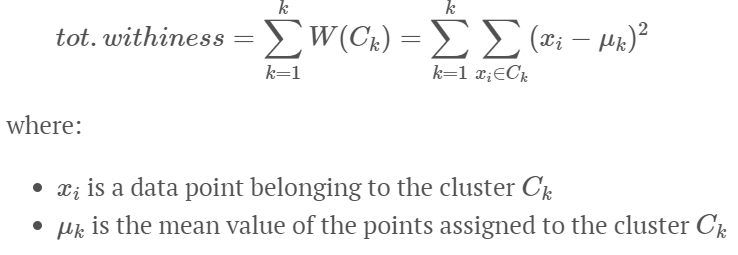
</div>

Алгоритм працюватиме допоки не виконається один з критеріїв закінчення:
   - кластери не змінилися під час останньої ітрації;
   - характеристики кластерів (діаметр, щільність, ...) досягли граничних значень;
   - побудована потрібна кількість кластерів

Для нашого завдання, у якому ми використовуємо алгоритм KMeans з бібліотеки scikit-learn це буде перший вищевказаний критерій закінчення.

#### Як визначити оптимальну кількість кластерів?

Для цього створимо цикл, у якому послідовно створюватимемо KMeans моделі з кількістю кластерів від 1 до 20 і зберігатимемо значення *інерції* для кожної з них.

In [18]:
rstate = 1

In [19]:
distorsions = []
silhouette = []

start = 1

kmeans_list = []

for k in tqdm(range(start, 21)):
    kmeans = KMeans(n_clusters=k, init='random', random_state=rstate).fit(df)
    kmeans_list.append(kmeans)
    distorsions.append(kmeans.inertia_)
    
    if k > 1:
        silhouette.append(silhouette_score(df, kmeans.fit_predict(df)))

  0%|          | 0/20 [00:00<?, ?it/s]

  File "C:\Users\alexa\anaconda3\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


Графічно отриманий результат виглядатиме наступним чином:

#### Elbow method

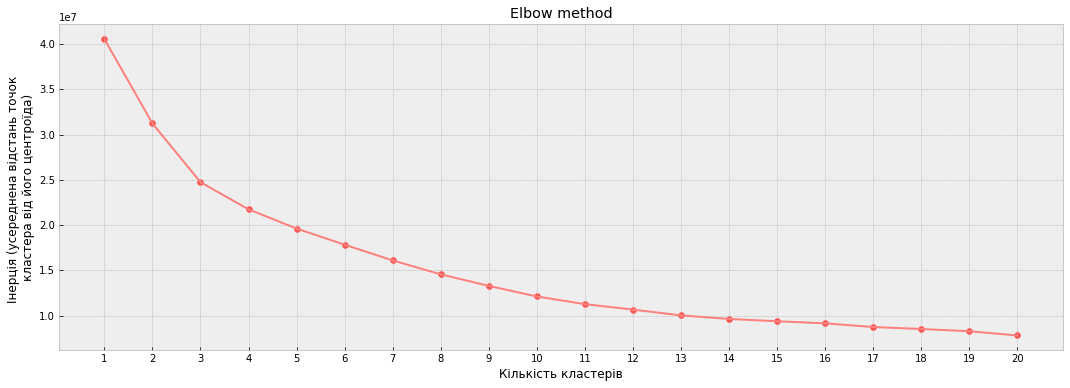

In [20]:
y_label = '''Інерція (усереднена відстань точок 
кластера від його центроїда)'''

plot_graph('Кількість кластерів', y_label, 'Elbow method', distorsions, start=1)

Ідея *elbow method*'у полягає у тому, що значення оптимальної кількості кластерів обирається на моменті, коли графік стає досить пласким: наша задача полягає у тому, щоб мінімізувати інерцію, тож нам достатньо обрати значення, на якому графік починає вирівнюватись у горизонтальну лінію. У нашому випадку таким значенням можна обрати **K = 13**

#### Average silhouette method

Ідея оцінки якості кластеризації за даним методом полягає у тому, щоб обрахувати для кожної *і*-тої точки середню відстань ($a_i$) до кожної іншої точки всередині свого кластеру:

<div>
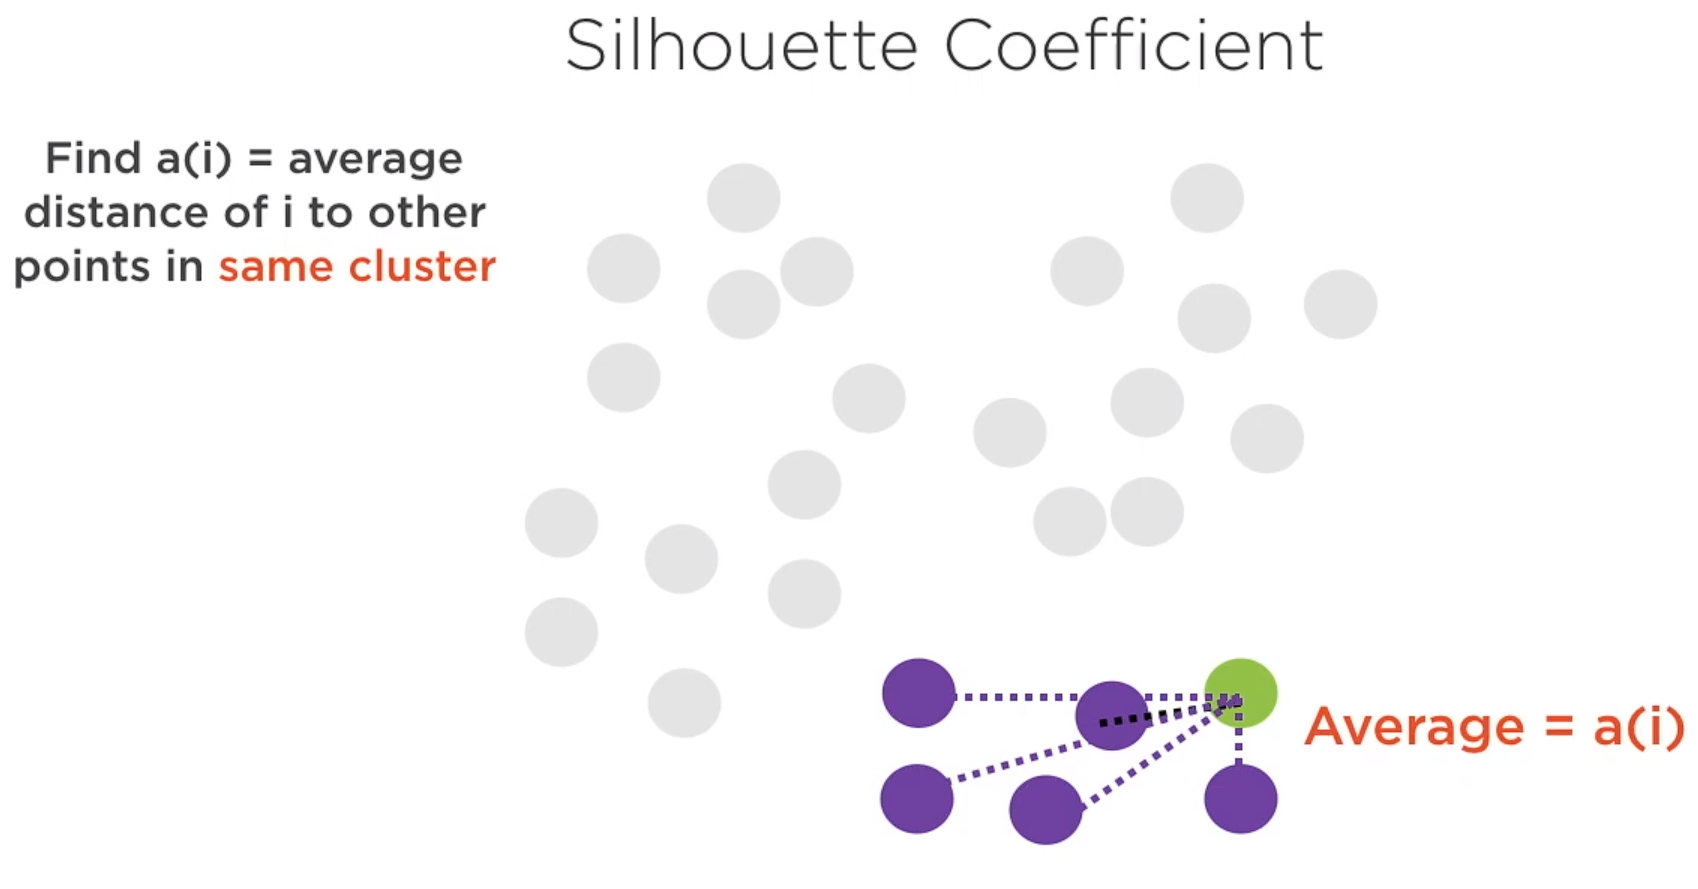
</div>

Потім середню відстань до кожної точки з найближчого сусіднього кластера до поточного кластера:

<div>
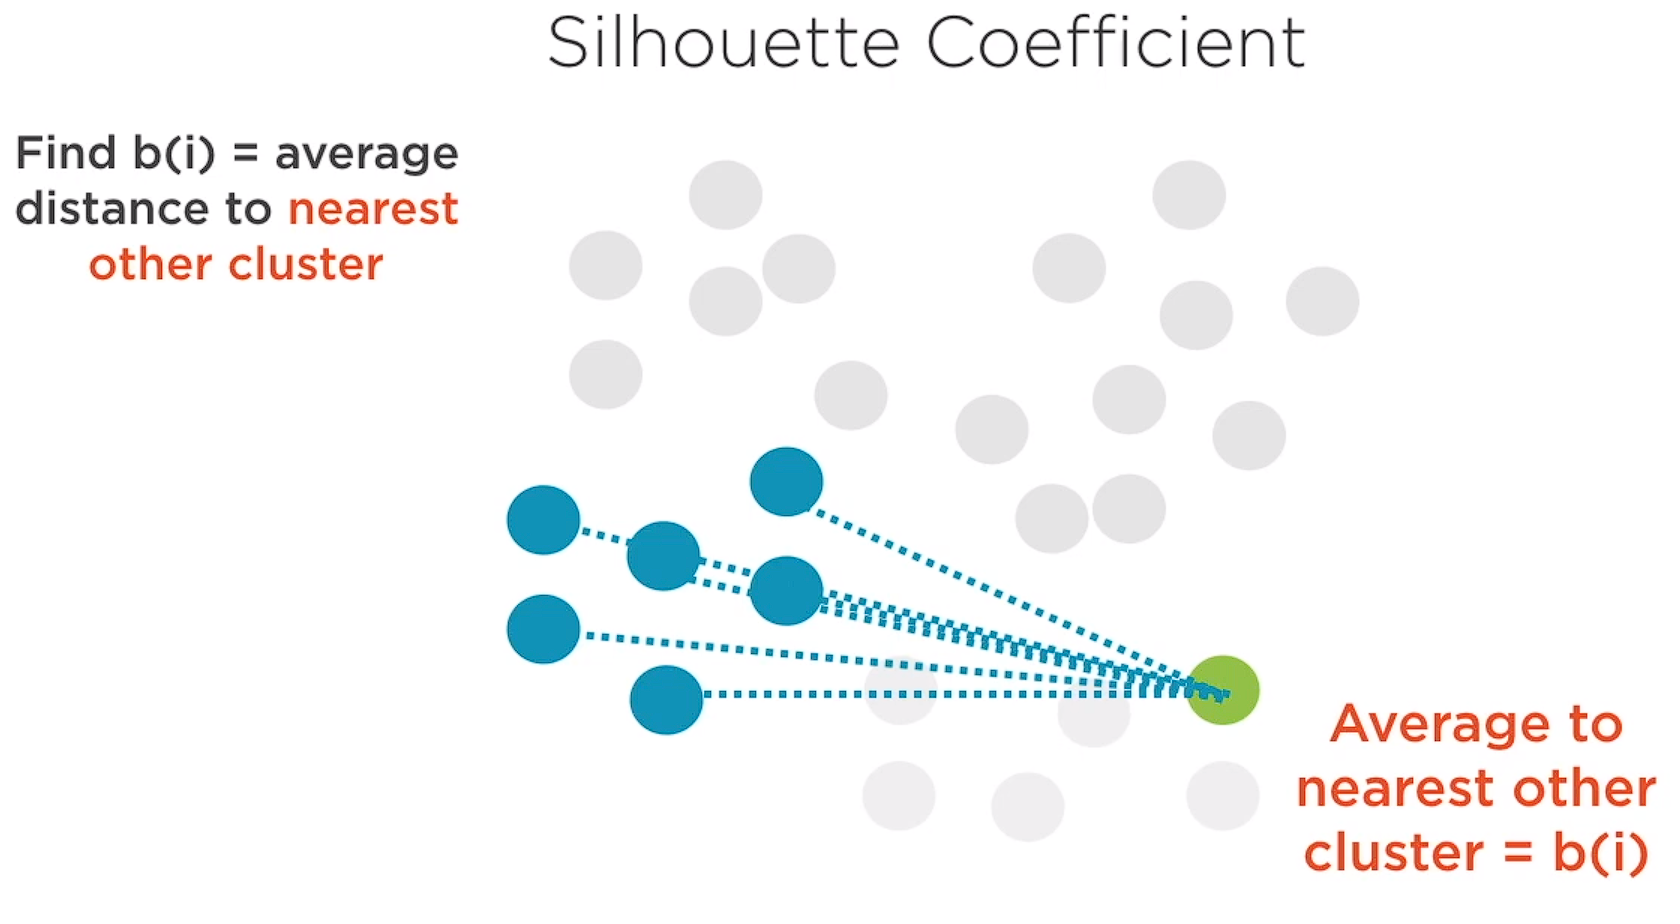
</div>

І далі порахувати *silhouette score* $s_i = \frac{b_i - a_i}{max(a_i, b_i)}$

Таким чином ми обраховуємо значення *$s_i$* для кожної точки *і* в кожному з кластерів і беремо їх середнє. Чим більшим вийде *average silhouette score* - тим якіснішою є кластеризація. Розглянемо графічно отриманий результат:

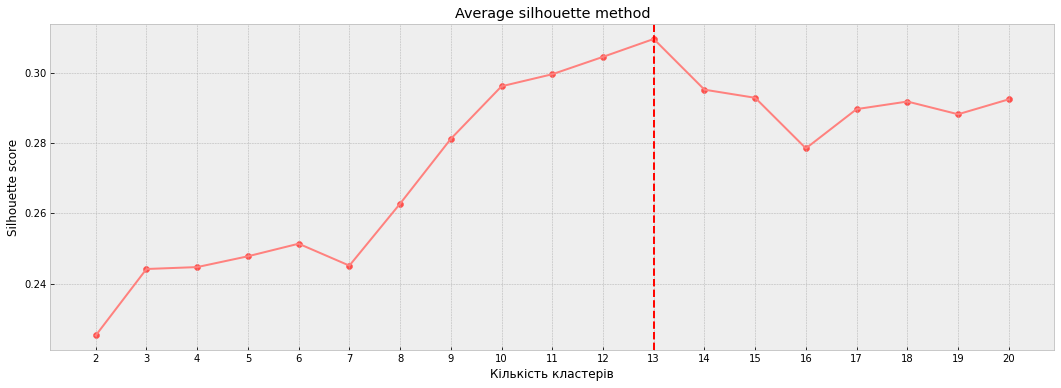

In [21]:
max_index = silhouette.index(max(silhouette))
max_x_value = max_index + 2

y_label2 = '''Silhouette score'''
plot_graph('Кількість кластерів', y_label2, 'Average silhouette method', silhouette, max_x_value=max_x_value, start=2)

Як бачимо, найбільше значення *silhouette score* досягається за **K = 12**

#### Prediction strength method

Якщо коротко, то ідея даного методу полягає у тому, щоб розбити набір даних на тренувальну та тестову вибірку, після чого натренувати на кожному з них окремо KMeans алгоритм із заданою кількістю у K кластерів. Після цього ми створюємо так звану *co-membership matrix*, це матриця розміром $n_{test}$ x $n_{test}$. У цій матриці ми по черзі беремо попарно елементи (i та i') з тестової вибірки і дивимось, належать вони одному кластеру чи ні. Якщо належать, ставимо у відповідну комірку 1, якщо ні - 0.


Далі, на основі цієї матриці, для кожного кластеру з тестової вибірки ми обраховуємо відношення кількості пар в одному кластері (сума одиничок), які присвоєні одному і тому ж кластеру з train вибірки, до загальної кількості елементів у цьому кластері з тестової вибірки.

<div>
<img src="attachment:image_2024-06-08_135538410.png" width="500"/>
</div>

<div>
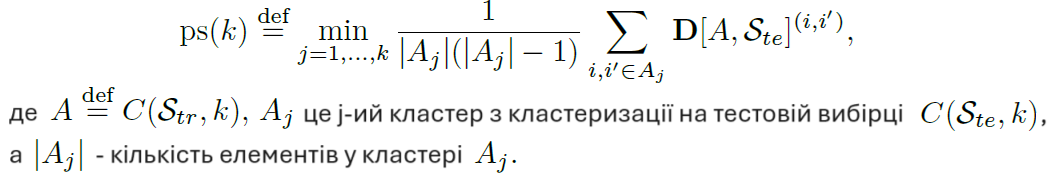
</div>

На прикладі:

<div>
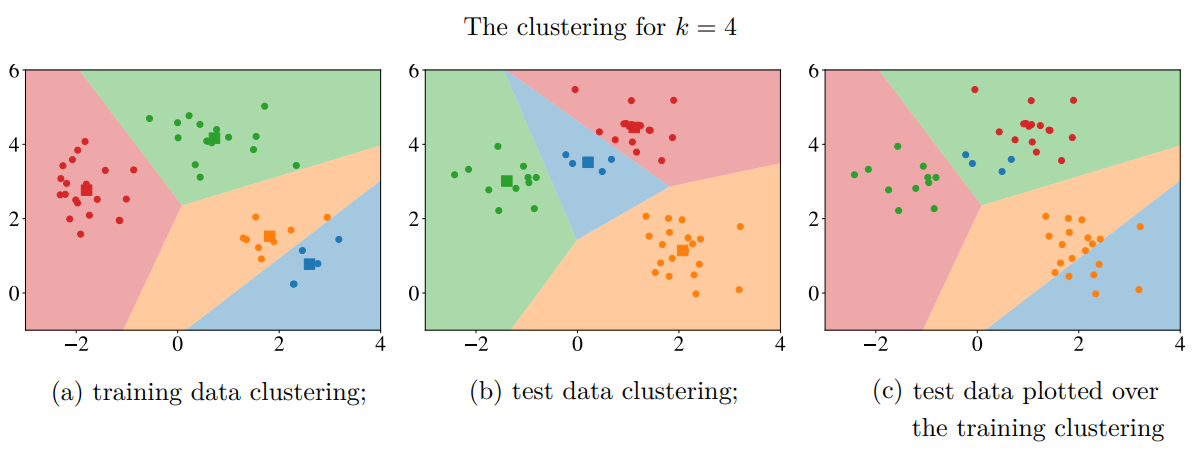
</div>

In [22]:
def closest_center(point, centroids):
    min_index = -1
    min_distance = float('inf')
    for i, center in enumerate(centroids):
        d = np.sum((point - center) ** 2)
        if d < min_distance:
            min_index = i
            min_distance = d
    return min_index

def calculate_prediction_strength(test_set, test_labels, training_centers, k):
    clusterLength = test_labels.tolist().count(k)
    if clusterLength <= 1:
        return float('inf')
    else:
        count = 0
        for i in range(len(test_labels) - 1): 
            for j in range(i + 1, len(test_labels)):
                if test_labels[i] == test_labels[j] == k:
                    p1 = test_set[i]
                    p2 = test_set[j]                        
                    if closest_center(p1, training_centers) == closest_center(p2, training_centers):
                        count += 1
        count = count / (clusterLength * (clusterLength - 1) / 2)
    return count

def prediction_strength_of_cluster(test_set, test_labels, training_centers, k):
    prediction_strengths = [calculate_prediction_strength(test_set, test_labels, training_centers, i) for i in range(k)]
    return min(prediction_strengths)    

In [23]:
def ps_score(X, k):
    rs = ShuffleSplit(n_splits=10, test_size=0.3, random_state=rstate)
    X = X.values
    ps=[]

    for train_index, test_index in rs.split(X):
        X_train, X_test = X[train_index], X[test_index]
        train_model = KMeans(n_clusters=k, init='random', random_state=rstate).fit(X_train)
        test_model = KMeans(n_clusters=k, init='random', random_state=rstate).fit(X_test)
        score = prediction_strength_of_cluster(X_test, test_model.labels_, train_model.cluster_centers_, k)
        ps.append(score)
    
    return max(ps)

In [24]:
prediction_strengths = [ps_score(df, K) for K in tqdm(range(2, 21))]

  0%|          | 0/19 [00:00<?, ?it/s]

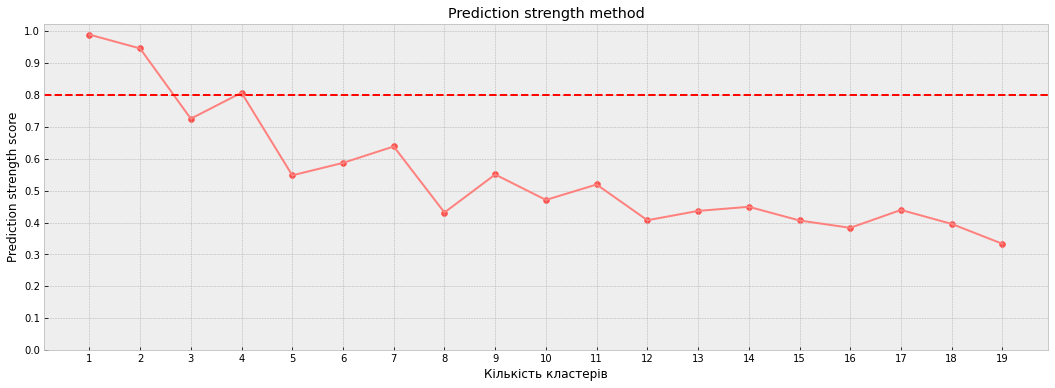

In [25]:
y_label3 = '''Prediction strength score'''
plot_graph('Кількість кластерів', y_label3, 'Prediction strength method', prediction_strengths, start=1)

На мою думку, prediction strength метод викликає більше довіри в силу того, що він видає більш стійкий (впевнений) результат, як на прикладі:

<div>
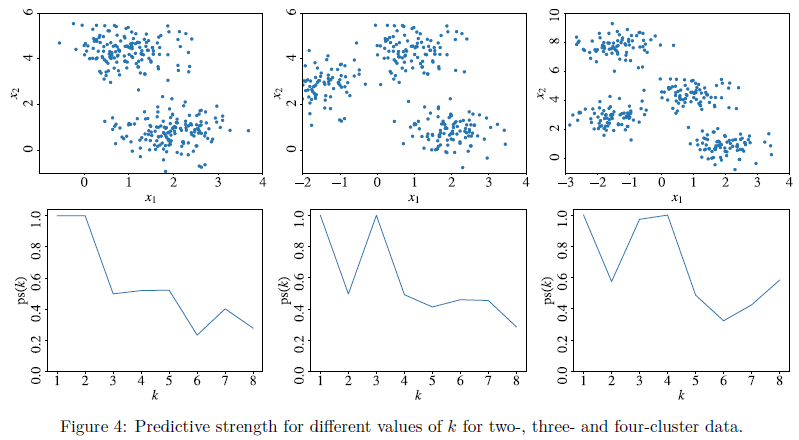
</div>

Координати центрів кластерів (за обраного **К**):

In [26]:
kmeans_list[3].cluster_centers_

array([[ 195.04160584,  180.36605839,   39.5620438 ,  191.38759124,
           4.37189781,  952.67737226,  743.25656934,   38.95620438],
       [ 369.24813278,   78.27842324,   35.52240664,  172.84149378,
           9.95020747,  898.30290456,  809.21452282,   30.80497925],
       [ 402.25      ,   22.17022472,   11.53370787,  193.63932584,
           2.1988764 , 1012.22303371,  699.02359551,   87.91573034],
       [ 224.24985163,   11.51632047,  101.95875371,  173.44658754,
           7.13204748, 1021.9768546 ,  812.13264095,   39.42136499]])

# 6. 
За раніш обраної кількості кластерів багаторазово проведіть кластеризацію методом *k*-середніх, використовуючи для початкової ініціалізації метод *k*-means++.

Виберіть найкращий варіант кластеризації. Який кількісний критерій Ви обрали для відбору найкращої кластеризації?

Ідея *k-means++* полягає у тому, що замість випадкової ініціалізації k центроїдів спочатку випадково обирається перший центроїв, а усі наступні вибираються як найвіддаленіша точка від попередніх центроїдів:

<div>
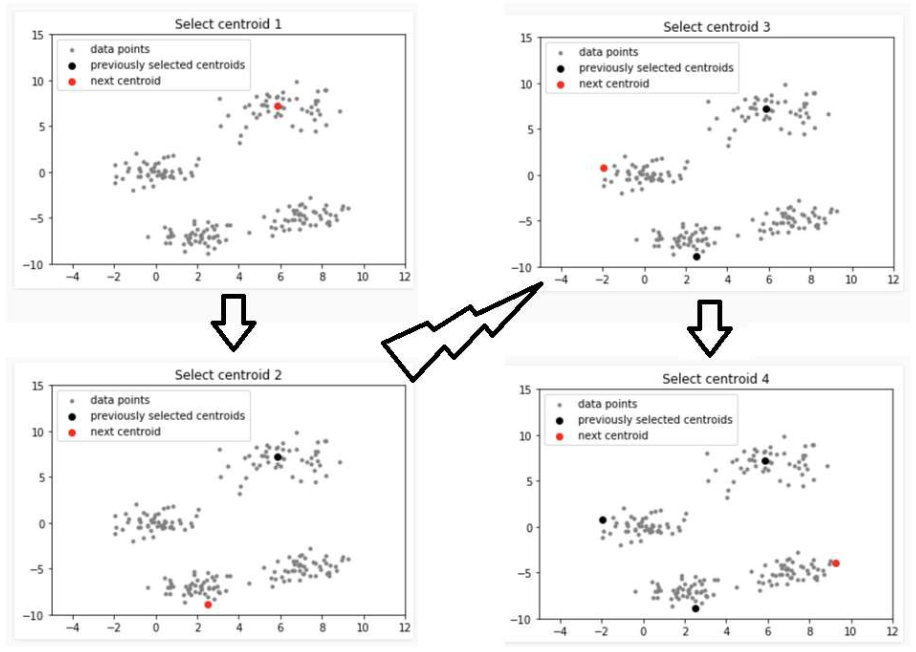
</div>

In [27]:
iters = 10

In [28]:
kmeanspp_models = []

In [29]:
for i in range(iters):
    kmeans_pp = KMeans(n_clusters=4, random_state=rstate+100*i, init='k-means++', n_init="auto").fit(df)
    kmeanspp_models.append(kmeans_pp)

In [30]:
def show_metrics(criterion, models):
    lst = []
    
    print(f'Критерій: {criterion}')
    for model in enumerate(models, 1):
        if criterion == 'average silhouette score':
            score = round(silhouette_score(df, model[1].fit_predict(df)), 3)
            print(f'{model[0]}. {score}')
        else:
            score = round(model[1].inertia_, 3)
            print(f'{model[0]}. {score}')
        lst.append(score)
        
    return lst

In [31]:
def plot_bar_chart(values, title, x_label='Index', y_label='Value'):
    x_labels = [str(i) for i in range(1, len(values)+1)]

    plt.bar(x_labels, values, color='blue', edgecolor='black')

    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    plt.show()

In [32]:
inertia = show_metrics('inertia', kmeanspp_models)

Критерій: inertia
1. 21839357.395
2. 21845623.422
3. 22600160.51
4. 22483667.073
5. 21858738.182
6. 22446709.632
7. 22337059.122
8. 21840211.422
9. 21750981.598
10. 22768544.677


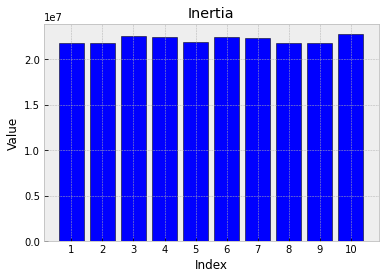

In [33]:
plot_bar_chart(inertia, title='Inertia')

In [34]:
silhouette = show_metrics('average silhouette score', kmeanspp_models)

Критерій: average silhouette score
1. 0.243
2. 0.244
3. 0.198
4. 0.239
5. 0.251
6. 0.232
7. 0.218
8. 0.242
9. 0.245
10. 0.215


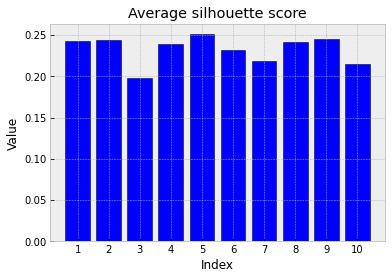

In [35]:
plot_bar_chart(silhouette, title='Average silhouette score')

In [36]:
rstate = rstate + silhouette.index(max(silhouette))*100

# 7.
Використовуючи функцію ***AgglomertiveClustering*** бібліотеки ***scikit-learn***, виконати розбиття набору даних на кластери. Кількість кластерів обрати такою ж самою, як і на попередньому методі. Вивести координати центрів кластерів.

Агломеративні алгоритми кластеризації - ієрархічні алгоритми, що на першому кроці розглядають кожну точку як кластер. Потім алгоритм намагаєтьсяо об'єднати найближчі сусідні точки в один більший кластер і так далі, щоб зрештою об'єднати всі кластери в один великий кластер.

<div>
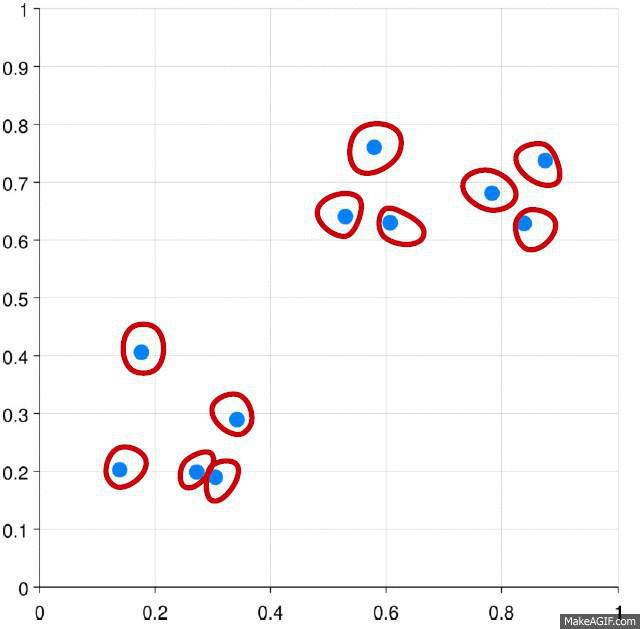
</div>

<div>
<img src="attachment:image_2024-06-08_173408176.png" width="400"/>
</div>

<div>
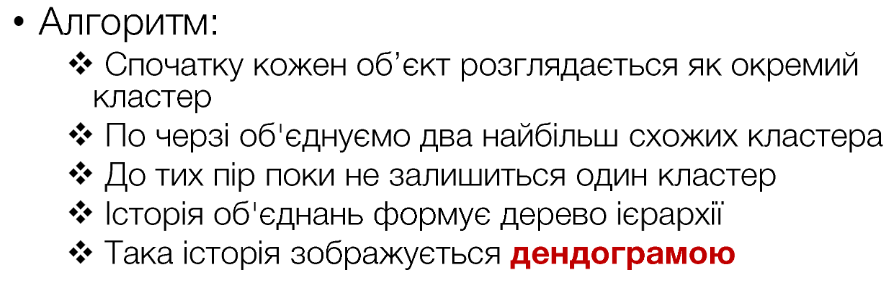
</div>

Для визначення подібності двох кластерів алгоритм використовує міру близькості. Для агломеративної кластеризації в даній лабораторній роботі використовується дефолтне значення, задане бібліотекою scikit-learn, а саме метод Уорда (Ward's method), що обчислює зважену близькість центроїдів.

In [37]:
AggClust = AgglomerativeClustering(n_clusters=4, metric='euclidean')
ys = AggClust.fit_predict(df)
clf = NearestCentroid()
clf.fit(df, ys)

NearestCentroid()

Координати центрів кластерів:

In [38]:
clf.centroids_

array([[ 265.12186235,   10.52408907,   79.1048583 ,  177.401417  ,
           5.90728745, 1008.31437247,  803.88036437,   36.96963563],
       [ 200.26818182,  172.5486014 ,   46.62657343,  188.76923077,
           5.18811189,  947.67762238,  748.64825175,   30.61888112],
       [ 415.35078125,   40.67421875,   26.5703125 ,  199.8828125 ,
           2.49140625,  969.5265625 ,  670.70546875,  123.140625  ],
       [ 395.00901639,  134.08688525,    0.        ,  162.33606557,
          13.68770492,  892.32786885,  817.27295082,   34.83606557]])

Дендрограма:

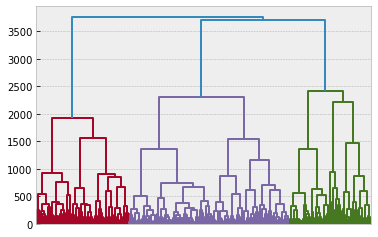

In [39]:
link = linkage(df, method='ward', metric='euclidean')
dnd = dendrogram(link, orientation='top', no_labels=True)

# 8.
Порівняти результати двох використаних методів кластеризації.

In [41]:
silhouettes = [silhouette_score(df, model.labels_) for model in models]

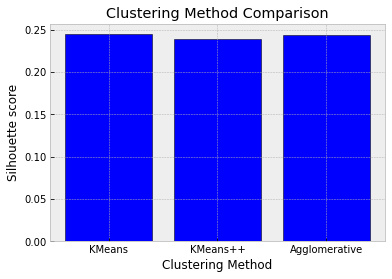

In [42]:
def plot_clustering_comparison(values, methods):
    plt.bar(methods, values, color='blue', edgecolor='black')

    plt.title('Clustering Method Comparison')
    plt.xlabel('Clustering Method')
    plt.ylabel('Silhouette score')

    # Show the plot
    plt.show()

methods = ['KMeans', 'KMeans++', 'Agglomerative']

plot_clustering_comparison(silhouettes, methods)